<h1> Automatic Processing draft 1 </h1>

setting up the sql server: (move this somewhere more privet when working and done: 

Python user + password:
<b> USER 'auto_processing'@'localhost' Password: 'dz_preProcess' </b>

for sake of experimentation - run Kyle's motion correction:

In [185]:
%matplotlib notebook 
%load_ext autoreload
%autoreload 2

import numpy as np

import multiprocessing as mp
import tifffile as tf 
from matplotlib import pyplot as plt
import h5py
from scipy.ndimage import median_filter, gaussian_filter, shift

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get a tif to play with 
a = tf.imread('/home/dana_z/handata2/Dana/0761/091518_day1/091518_0761_day1(00001).tif')
refImage = a[0]

<IPython.core.display.Javascript object>


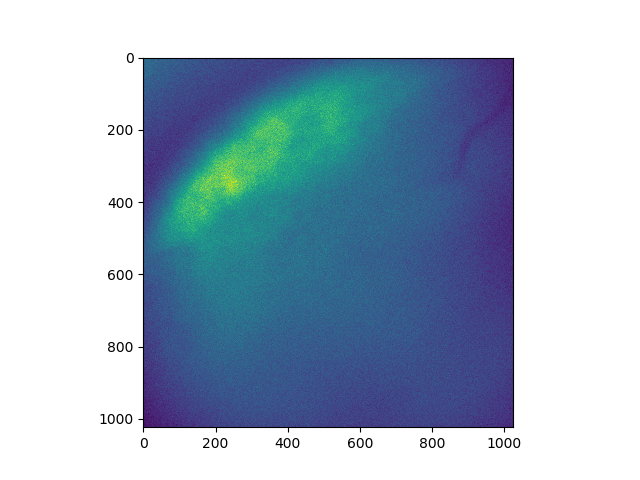

In [4]:
plt.imshow(refImage)


In [103]:
refImage = a[0].max()-a[0]
d = np.floor(1.14*refImage-gaussian_filter(refImage, sigma=50)).astype('uint8')
minP = d.min()
maxP = d.max()
n = d.shape[0]*d.shape[1]

P = [np.sum(d==p)/n for p in range(minP,maxP+1)]
cdf = np.cumsum(P)
cdfV = np.ma.masked_equal(cdf,0)
Hv = (cdfV-cdfV.min())*255/(n-cdfV.min())
cdf = np.ma.filled(Hv,0).astype('uint8')
c = Hv[d]

<IPython.core.display.Javascript object>


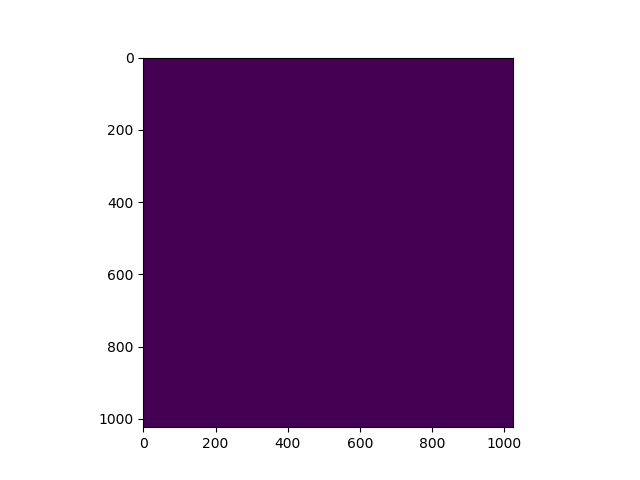

In [104]:
plt.imshow(c)

In [142]:
def mc_helper(args):
    return MotionCorrect_1(*args)

def MotionCorrect_1(frame, ref, imCenter):
    # manipulate frame to match image
    d = np.floor(1.14*refImage-gaussian_filter(frame, sigma=50)).astype('uint8')
    minP = d.min()
    maxP = d.max()
    n = d.shape[0]*d.shape[1]

    P = [np.sum(d==p)/n for p in range(minP,maxP+1)]
    cdf = np.cumsum(P)
    cdfV = np.ma.masked_equal(cdf,0)
    Hv = (cdfV-cdfV.min())*255/(n-cdfV.min())
    cdf = np.ma.filled(Hv,0).astype('uint8')
    c = Hv[d]
    
    cim = np.fft.fft2(c)*ref
    cim = abs(np.fft.ifft2(cim))
    xcpeak = np.array(np.unravel_index(np.argmax(np.fft.fftshift(cim)), imshape))
    disps = imcenter - xcpeak
    
    del c
    del d
    
    return {'f':np.uint16(shift(frame, (disps[0], disps[1]))),'g':disps}
    

<b> That was really really really bad! (like horrible - the worse yet!) </b>

so......

try again, using Mike/Kyle method, but writen in python and optimized for speed

In [179]:
def mc_helper2(args):
    return MC_fallback(*args)

def MC_fallback(frame, ref, imCenter, sig, eps, sFactor, baseline):
    # manipulate frame to match image
    logimg = np.log1p(np.maximum((frame-baseline)*sFactor, eps))
    lp = gaussian_filter(logimg, sigma=sig)
    adjimg = logimg - lp
    adjimg = adjimg - adjimg.min()
    adjimg = (np.expm1(adjimg)/sFactor) + baseline
    
    # find shifts:
    cim = np.fft.fft2(adjimg)*ref
    cim = abs(np.fft.ifft2(cim))
    xcpeak = np.array(np.unravel_index(np.argmax(np.fft.fftshift(cim)), imshape))
    disps = imcenter - xcpeak
    
    return {'original':np.uint16(shift(frame, (disps[0], disps[1]))),'shifts':disps,'filtered':np.uint16(shift(adjimg, (disps[0], disps[1])))}
    

In [186]:
#a,b = makeReferenceFrame(fileList[0], saveDir='/home/dana_z/HD1/Processed_tifs')
n_cores = mp.cpu_count()
pool = mp.Pool(processes=n_cores)
ref = np.fft.fft2(adjimg).conjugate()

imshape = a.shape[1:]
imcenter = np.array(imshape)/2
eps = 7./3 - 4./3 -1 
maxval = a.max()
sFactor = 1./maxval
baseline = a.min()
sig = 35
    

imList = [[img, ref,imcenter,sig,eps,sFactor,baseline] for img in a]

#corectedTif, shift = pool.map(mc_helper,imList)
results = pool.map(mc_helper2,imList)

pool.close()

In [187]:
from PIL import Image
outputs = [Image.fromarray(s['original']) for s in results]
#outputs = np.asarray(outputs)
#outputs.shape
    


In [188]:
outputs[0].save('/home/dana_z/HD1/try1.tif',save_all = True,append_images=outputs[1:])

In [172]:
sFactor = 1./maxval
baseline = a.min()
sig = 35
logimg = np.log1p(np.maximum((a[0]-baseline)*sFactor, eps))
lp = gaussian_filter(logimg, sigma=sig)
adjimg = logimg - lp
adjimg = adjimg - adjimg.min()
adjimg = (np.expm1(adjimg)/sFactor) + baseline

In [199]:
f = 1
saveDir = '/home/dana_z/HD1/Processed'
suffix = '0761_day1'
saveDir +'/' +'m_'+suffix +'_'+str(f).zfill(4)+'.tif'

'/home/dana_z/HD1/Processed/m_0761_day1_0001.tif'